# Electronic strong coupling with HCN

Here, we introduce how to use MaxwellLink to run nonadiabatic cavity molecular dynamics (CavMD) simulations for a single HCN molecule under electronic strong coupling. Similar as the two-level system (TLS) example, we will keep using the non-socket mode for simplicity.

## 1. HCN TDDFT spectrum

We use HCN molecules for our calculations. Before running simulations inside the cavity, we first examine the linear-response and real-time TDDFT spectrum using existing helper functions in MaxwellLink. 

For demonstration purpose, below we use only Hartree-Fock exchange `scf` instead of using DFT functionals. Please change `functional="scf"` to, e.g., `functional="b3lyp"` if you are interested in using DFT functionals.

In [1]:
import maxwelllink as mxl

dt_rttddft_au = 0.04  # Time step in atomic units

model = mxl.RTTDDFTModel(
    molecule_xyz="../tests/data/hcn.xyz",
    functional="scf",
    basis="sto-3g",
    dt_rttddft_au=dt_rttddft_au,
    delta_kick_au=1.0e-3,
    delta_kick_direction="xyz",
)

model.initialize(dt_new=dt_rttddft_au, molecule_id=0)

# calculate LR-TDDFT spectrum
poles, oscillator_strengths, res = model._get_lr_tddft_spectrum(states=28, tda=False, savefile=False)

# propagate standalone RT-TDDFT
times, energies, dipoles = model._propagate_full_rt_tddft(nsteps=20000, savefile=False)


  Memory set to   7.451 GiB by Python driver.
  Threads set to 1 by Python driver.
Initial SCF energy: -91.6751251525 Eh
Energy (eV): [  7.39216    8.554808   8.554808  10.736077  10.736077  16.312226
  16.66767   16.66767   20.471168  20.471168  21.43112   26.012462
  28.913028  28.913028  33.561233  33.561233  36.688199  38.894917
  45.046956  54.541618 293.643446 293.643446 300.061695 315.270765
 409.606912 409.606912 420.525104 436.943481]
Oscillator strengths: [0.       0.       0.       0.048238 0.048238 0.325466 0.015787 0.015787
 0.321606 0.321606 1.485709 0.395643 0.001497 0.001497 0.001597 0.001597
 0.018092 0.440584 0.000609 0.272348 0.072062 0.072062 0.017407 0.109402
 0.065    0.065    0.04641  0.032024]
Step 20000 Time 800.000000  Etot = -91.6751251337 Eh  ΔE = 0.0000000188 Eh,  μx = -0.000053 a.u.,  μy = -0.000053 a.u.,  μz = 0.965393 a.u.


Now we compare the linear-response versus real-time TDDFT spectra of the HCN molecule. The agreement showcases the validity of our implementation of real-time TDDFT.

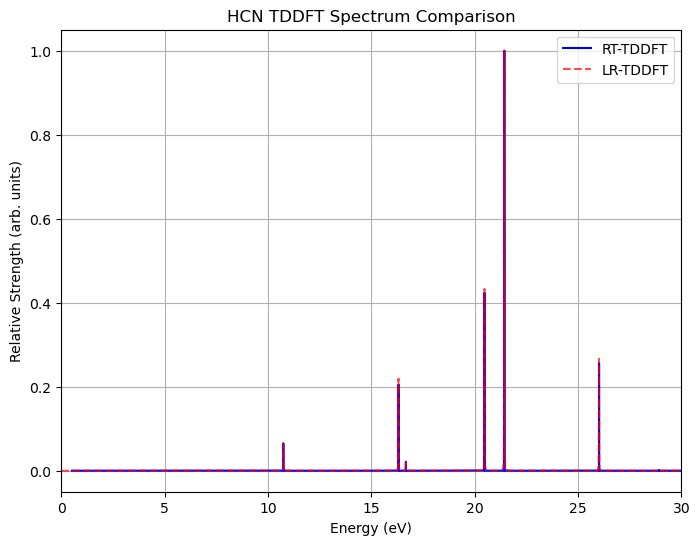

In [2]:
from maxwelllink.tools import rt_tddft_spectrum, lr_tddft_spectrum
import matplotlib.pyplot as plt
import numpy as np

nskip = 10
mux, muy, muz = dipoles[::nskip, 0], dipoles[::nskip, 1], dipoles[::nskip, 2]
sp_tot = 0.0
for mu in [mux, muy, muz]:
    freq_ev, sp, _, _ = rt_tddft_spectrum(mu, dt_au=dt_rttddft_au*nskip, sp_form="absorption", e_start_ev=0.5, e_cutoff_ev=30.0, sigma=1e5, w_step=1e-5)
    sp_tot += sp

freq_ev_lr, sp_lr = lr_tddft_spectrum(poles, oscillator_strengths, e_cutoff_ev=30.0, linewidth=1e-2, w_step=1e-5)

plt.figure(figsize=(8, 6))
plt.plot(freq_ev, sp_tot / np.max(sp_tot), label="RT-TDDFT", color="blue")
plt.plot(freq_ev_lr, sp_lr / np.max(sp_lr), label="LR-TDDFT", color="red", linestyle="--", alpha=0.7)
plt.xlim(0, 30)
plt.xlabel("Energy (eV)")
plt.ylabel("Relative Strength (arb. units)")
plt.title("HCN TDDFT Spectrum Comparison")
plt.legend()
plt.grid()
plt.show()


With the above simulations in mind, now let's try to find the strongest absorption peak of the HCN molecule. 

Apparently, the strongest peak locates at 0.7876 a.u. (21.4311 eV), with the $z$-component transition dipole momemnt $\mu_z$ being 1.68215282 a.u. 

In [3]:
poles = np.array([r["EXCITATION ENERGY"] for r in res])

tdm_len = np.array(
                [r["ELECTRIC DIPOLE TRANSITION MOMENT (LEN)"] for r in res]
            )

print("Excitation Energies (a.u.):\n", poles)
print("Transition Dipole Moments (a.u.):\n", tdm_len)

# Identify the strongest absorption peak
idx = np.argmax(oscillator_strengths)
print(f"The strongest absorption peak is at {poles[idx]:.4f} a.u. ({poles[idx]*27.2114:.4f} eV) with oscillator strength {oscillator_strengths[idx]:.4f}.")
print(f"The transition dipole vector of this transition is {tdm_len[idx]} a.u.")

Excitation Energies (a.u.):
 [ 0.27165675  0.31438324  0.31438324  0.39454339  0.39454339  0.59946297
  0.61252527  0.61252527  0.75230118  0.75230118  0.78757876  0.9559399
  1.06253368  1.06253368  1.233352    1.233352    1.34826581  1.42936118
  1.65544433  2.00436654 10.79119256 10.79119256 11.02705875 11.58598147
 15.0527693  15.0527693  15.45400529 16.05736922]
Transition Dipole Moments (a.u.):
 [[ 1.44319961e-14 -1.14366467e-14  9.14781101e-14]
 [ 4.67424858e-14 -1.84383439e-15  4.66823985e-14]
 [ 1.53669112e-14 -7.83906771e-15  1.58152649e-13]
 [ 4.25650158e-01  4.70958067e-02  3.70552495e-14]
 [ 4.70958067e-02 -4.25650158e-01  1.63266884e-14]
 [ 1.22137605e-14 -2.46723311e-15 -9.02438307e-01]
 [ 1.80662697e-01 -7.75936885e-02 -7.28918027e-14]
 [ 7.75936885e-02  1.80662697e-01 -6.79331050e-15]
 [-5.98909780e-01 -5.31555617e-01 -1.73525464e-15]
 [-5.31555617e-01  5.98909780e-01 -2.29614381e-15]
 [ 7.38807736e-15 -1.14460340e-15  1.68215282e+00]
 [-1.74857013e-15 -1.35772295e-16 

## 2. A single TDDFT HCN coupled to a single-mode cavity

Now, we use MaxwellLink to resonantly couple a single-mode cavity to a realistic HCN molecule described by real-time TDDFT.

In [4]:
molecule = mxl.Molecule(
    rescaling_factor=1.0,
    driver="rttddft",
    driver_kwargs={
        "molecule_xyz" : "../tests/data/hcn.xyz",
        "functional" : "scf",
        "basis" : "sto-3g",
        "dt_rttddft_au" : dt_rttddft_au,
    }
)

sim = mxl.SingleModeSimulation(
    molecules=[molecule],
    frequency_au=0.7876,
    coupling_strength=2e-2,
    damping_au=0.0,
    coupling_axis="z",
    drive=0.0,
    dt_au=dt_rttddft_au,
    qc_initial=[0, 0, 1e-3],
    record_history=True,
    include_dse=True,
)

sim.run(steps=10000)

[Init Molecule] Operating in non-socket mode, using driver: rttddft
Initial SCF energy: -91.6751251525 Eh
[SingleModeCavity] Completed 1000/10000 [10.0%] steps, time/step: 5.71e-04 seconds, remaining time: 5.14 seconds.
[SingleModeCavity] Completed 2000/10000 [20.0%] steps, time/step: 5.63e-04 seconds, remaining time: 4.54 seconds.
[SingleModeCavity] Completed 3000/10000 [30.0%] steps, time/step: 5.67e-04 seconds, remaining time: 3.97 seconds.
[SingleModeCavity] Completed 4000/10000 [40.0%] steps, time/step: 5.73e-04 seconds, remaining time: 3.41 seconds.
[SingleModeCavity] Completed 5000/10000 [50.0%] steps, time/step: 5.69e-04 seconds, remaining time: 2.84 seconds.
[SingleModeCavity] Completed 6000/10000 [60.0%] steps, time/step: 5.60e-04 seconds, remaining time: 2.27 seconds.
[SingleModeCavity] Completed 7000/10000 [70.0%] steps, time/step: 5.72e-04 seconds, remaining time: 1.70 seconds.
[SingleModeCavity] Completed 8000/10000 [80.0%] steps, time/step: 5.63e-04 seconds, remaining ti

We then analyze the photonic coordinate, molecular dipole, and energy dynamics using the helper functions provided in MaxwellLink.

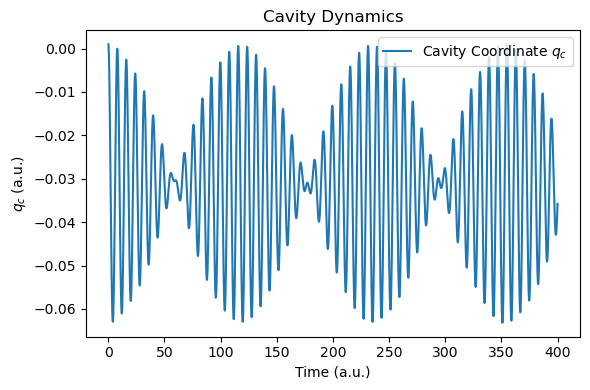

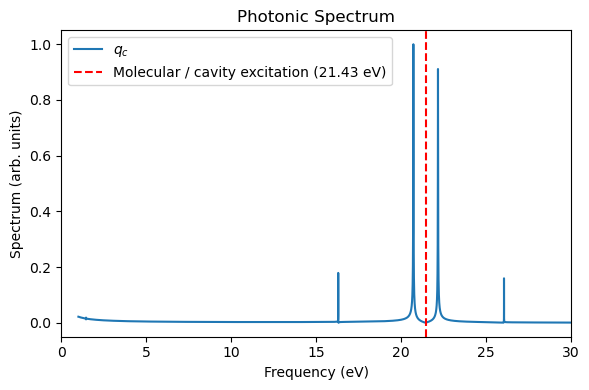

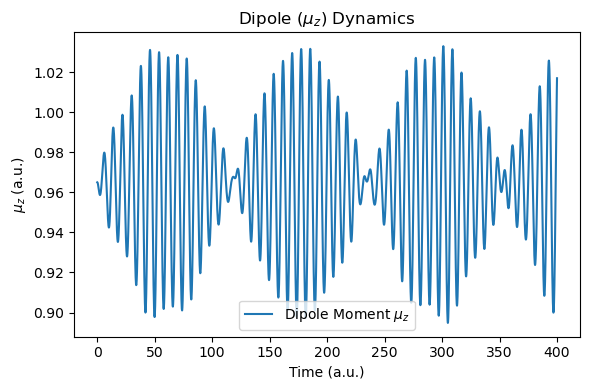

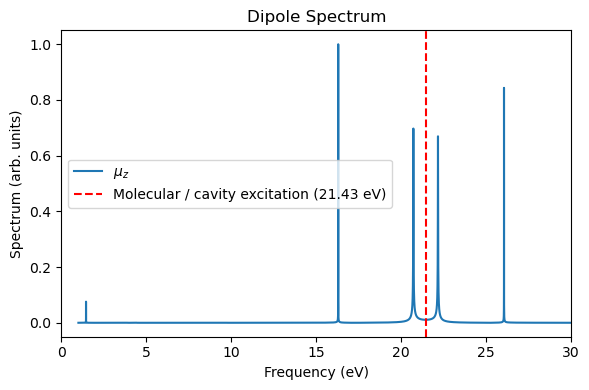

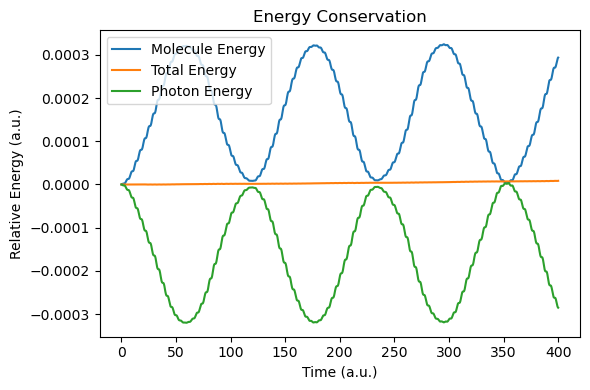

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from maxwelllink.tools import rt_tddft_spectrum
nskip = 10

def plot_photon_data(sim, t_ref=None, qc_ref=None):
    t = np.array(sim.time_history)
    # qc[-1] is the z-direction cavity coordinate
    qc = np.array([qc[-1] for qc in sim.qc_history])
    dt_au = t[1] - t[0]
    freq_ev, sp, _, _ = rt_tddft_spectrum(qc[::nskip], dt_au=dt_au*nskip, sp_form="absolute", e_start_ev=1.0, e_cutoff_ev=35.0, sigma=1e5, w_step=1e-5)

    if t_ref is not None and qc_ref is not None:
        freq_ev_ref, sp_ref, _, _ = rt_tddft_spectrum(qc_ref[::nskip], dt_au=dt_au*nskip, sp_form="absolute", e_start_ev=1.0, e_cutoff_ev=35.0, sigma=1e5, w_step=1e-5)

    plt.figure(figsize=(6, 4))
    plt.plot(t, qc, label="Cavity Coordinate $q_c$")
    if t_ref is not None and qc_ref is not None:
        plt.plot(t_ref, qc_ref, label="Reference $q_c$", linestyle="--")
    plt.xlabel("Time (a.u.)")
    plt.ylabel("$q_c$ (a.u.)")
    plt.title("Cavity Dynamics")
    plt.legend()
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(6, 4))
    plt.plot(freq_ev, sp / np.max(sp), label="$q_c$")
    if t_ref is not None and qc_ref is not None:
        plt.plot(freq_ev_ref, sp_ref / np.max(sp_ref), label="Reference $q_c$", linestyle="--")
    plt.xlabel("Frequency (eV)")
    plt.ylabel("Spectrum (arb. units)")
    plt.xlim(0, 30)
    plt.axvline(21.4311, color="red", linestyle="--", label="Molecular / cavity excitation (21.43 eV)")
    plt.title("Photonic Spectrum")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return t, qc

def plot_dipole_data(molecule):
    t = np.array([data["time_au"] for data in molecule.additional_data_history])
    muz = np.array([data["muz_au"] for data in molecule.additional_data_history])
    dt_au = t[1] - t[0]
    freq_ev, sp, _, _ = rt_tddft_spectrum(muz[::nskip], dt_au=dt_au*nskip, sp_form="absolute", e_start_ev=1.0, e_cutoff_ev=35.0, sigma=1e5, w_step=1e-5)

    plt.figure(figsize=(6, 4))
    plt.plot(t, muz, label="Dipole Moment $\\mu_z$")
    plt.xlabel("Time (a.u.)")
    plt.ylabel("$\\mu_z$ (a.u.)")
    plt.title("Dipole ($\\mu_z$) Dynamics")
    plt.legend()
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(6, 4))
    plt.plot(freq_ev, sp / np.max(sp), label="$\\mu_z$")
    plt.xlabel("Frequency (eV)")
    plt.ylabel("Spectrum (arb. units)")
    plt.xlim(0, 30)
    plt.axvline(21.4311, color="red", linestyle="--", label="Molecular / cavity excitation (21.43 eV)")
    plt.title("Dipole Spectrum")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_energy_analysis(sim, molecule):
    t = np.array(sim.time_history)
    energy_molecule = np.array([ad["energy_au"] for ad in molecule.additional_data_history])
    energy_tot = np.array(sim.energy_history)
    energy_photon = energy_tot - energy_molecule

    plt.figure(figsize=(6, 4))
    plt.plot(t, energy_molecule - energy_molecule[0], label="Molecule Energy")
    plt.plot(t, energy_tot - energy_tot[0], label="Total Energy")
    plt.plot(t, energy_photon - energy_photon[0], label="Photon Energy")
    plt.xlabel("Time (a.u.)")
    plt.ylabel("Relative Energy (a.u.)")
    plt.title("Energy Conservation")
    plt.legend()
    plt.tight_layout()
    plt.show()

t_tddft, qc_tddft = plot_photon_data(sim)
plot_dipole_data(molecule)
plot_energy_analysis(sim, molecule)

## 3. A single RT-Ehrenfest HCN coupled to a single-mode cavity

The real-time TDDFT simulation assumes fixed nuclei. We can also enable the nuclear motion in the HCN molecule by performing real-time Ehrenfest dynamcis for the HCN molecule. This simulation takes approximately 2.5 minutes in an old MacBook Pro M1.

In [6]:
molecule = mxl.Molecule(
    rescaling_factor=1.0,
    driver="rtehrenfest",
    driver_kwargs={
        "molecule_xyz" : "../tests/data/hcn.xyz",
        "functional" : "scf",
        "basis" : "sto-3g",
        "dt_rttddft_au" : dt_rttddft_au,
    }
)

sim = mxl.SingleModeSimulation(
    molecules=[molecule],
    frequency_au=0.7876,
    coupling_strength=2e-2,
    damping_au=0.0,
    coupling_axis="z",
    drive=0.0,
    dt_au=dt_rttddft_au,
    qc_initial=[0.0, 0.0, 1e-3],
    record_history=True,
    include_dse=True,
)

sim.run(steps=10000)

[Init Molecule] Operating in non-socket mode, using driver: rtehrenfest
Initial SCF energy: -91.6751251525 Eh
[SingleModeCavity] Completed 1000/10000 [10.0%] steps, time/step: 1.87e-02 seconds, remaining time: 168.14 seconds.
[SingleModeCavity] Completed 2000/10000 [20.0%] steps, time/step: 1.88e-02 seconds, remaining time: 150.01 seconds.
[SingleModeCavity] Completed 3000/10000 [30.0%] steps, time/step: 1.93e-02 seconds, remaining time: 132.49 seconds.
[SingleModeCavity] Completed 4000/10000 [40.0%] steps, time/step: 2.06e-02 seconds, remaining time: 116.11 seconds.
[SingleModeCavity] Completed 5000/10000 [50.0%] steps, time/step: 2.15e-02 seconds, remaining time: 98.88 seconds.
[SingleModeCavity] Completed 6000/10000 [60.0%] steps, time/step: 2.04e-02 seconds, remaining time: 79.55 seconds.
[SingleModeCavity] Completed 7000/10000 [70.0%] steps, time/step: 2.02e-02 seconds, remaining time: 59.78 seconds.
[SingleModeCavity] Completed 8000/10000 [80.0%] steps, time/step: 1.93e-02 second

After the simulation, we now compare the spectra with those of the RT-TDDFT simulation. Due to the nuclear motion, under this short period of time (400 a.u.), the molecular dipole moment exhibits small drift, but energy conservation is still reasonable.

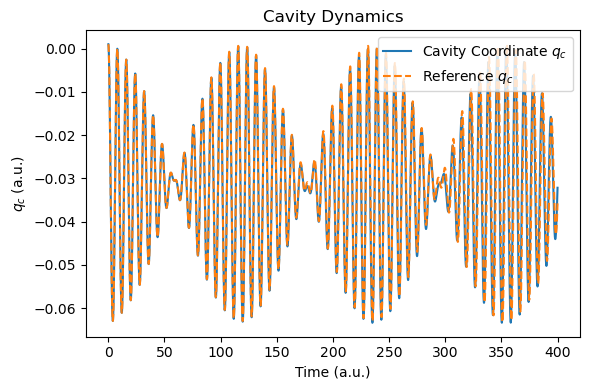

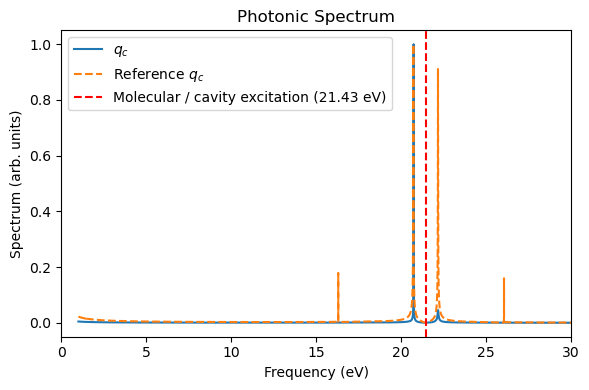

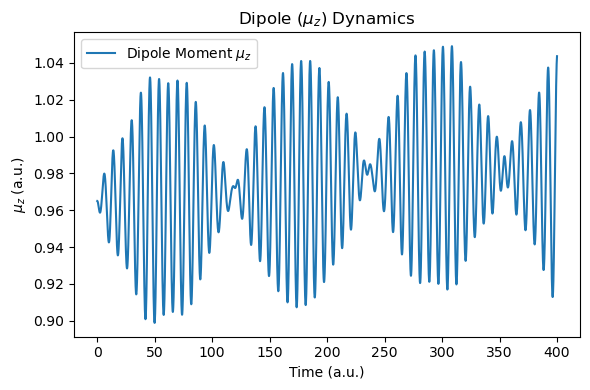

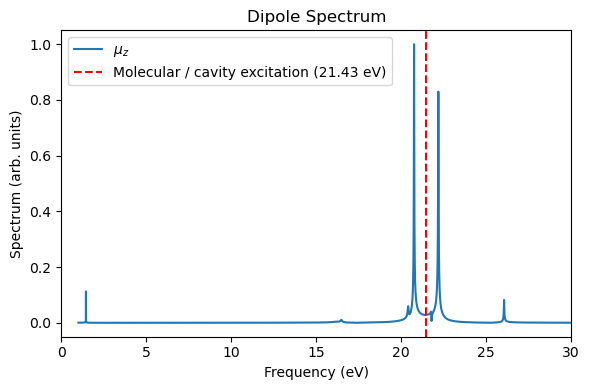

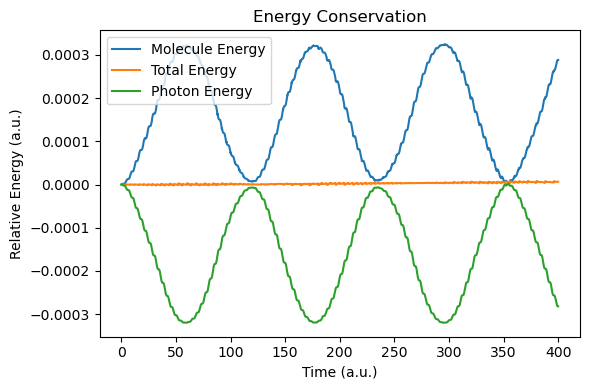

In [7]:
plot_photon_data(sim, t_ref=t_tddft, qc_ref=qc_tddft)
plot_dipole_data(molecule)
plot_energy_analysis(sim, molecule)